In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

## Kinetic model of enzyme inactivation in differential scanning calorimetry (DSC)

#### Assumptions
* two enzyme sub-species (e.g., with Ca2+ present or absent)
* each sub-species decays with 1st order kinetics with different parameter values
* in addition, auto-proteolysis for both sub-species (2nd order kinetics) with identical parameter values
* no exchange between subspecies

#### Model equations

\begin{align}
 \frac{dA_1}{dt} &= - r_1(T) \cdot A_1(t) - r_P(T) \cdot A_1(t)\cdot A(t), \\
 \frac{dA_2}{dt} &= - r_2(T) \cdot A_2(t) - r_P(T) \cdot A_2(t)\cdot A(t), \\
 A(t) &= A_1(t) + A_2(t), \\
 r_1(T) &= k_1 e^{-\frac{E_{a1}}{R}\left(\frac{1}{T}-\frac{1}{T_\textrm{ref}}\right)}\\
 r_2(T) &= k_2 e^{-\frac{E_{a2}}{R}\left(\frac{1}{T}-\frac{1}{T_\textrm{ref}}\right)}\\
 r_P(T) &= k_P e^{-\frac{E_{aP}}{R}\left(\frac{1}{T}-\frac{1}{T_\textrm{ref}}\right)}\\
\end{align}

#### Quantities
* $A_1(t)$ ... amount of enzyme sub-species 1 (e.g., with Ca2+ present), in nmol
* $A_2(t)$ ... amount of enzyme sub-species 2 (e.g., with Ca2+ absent), in nmol
* $A(t)$ ... total amount of enzyme, in g/L
* $T$ ... temperature in K
* $R$ ... universal gas costant (8.314E-3 kJ/mol/K)
* $k_1, k_2, k_P$ ... pre-exponential factor of Arrhenius equation, in 1/s
* $E_{a1}, E_{a1}, E_{aP}$ ... activation energy, in kJ/mol
* $T_\textrm{ref}$ ... reference temperature (80°C) for pre-exponential factor $k$



In [49]:
## in this cell: set parameters for simulation

# set kinetic parameters
k_1 = .1 # Arrhenius prefactor (at T=T_ref)
k_2 = .5 # Arrhenius prefactor (at T=T_ref)
k_P = .4 # Arrhenius prefactor autoproteolysis (at T=T_ref)
T_ref = 273.15+80 # reference temp. for k0
E_a1 = 250 # activation energy in kJ/mol
E_a2 = 150# activation energy in kJ/mol
E_aP = 100# activation energy in kJ/mol
R = 8.314e-3 # gas constant in kJ/mol

# set DSC parameters
T_ramp = 1 # temperatur ramp of DSC in °C/s
T0 = 25 # initial temperatur of DSC in °C
T_max = 80 # duration of DSC run, in sec

# set initial activities
A_init = 1 # initial (total) enzyme amount in nmol
fraction_A1_init =.55 # initial fraction of sub-species 1 (w.r.t. to A_init)

In [50]:
## in this cell: define dynamics and solve it

def T(t):
    # temperature in K at given time t
    return (T0+273.15) + T_ramp*t

def rhs_DSC(t, y):
    # right hand side of mass balance equations (ODE system)
    
    # unpack state variables (enzyme amount of both species)
    A1, A2 = y
    
    # calc specific rates
    r1 = k_1* np.exp(-E_a1/R*(1/T(t)-1/T_ref))
    r2 = k_2* np.exp(-E_a2/R*(1/T(t)-1/T_ref))
    rP = k_P* np.exp(-E_aP/R*(1/T(t)-1/T_ref))
    
    # total amount of enzyme
    A = A1 + A2
    
    # mass balance
    dA1dt = - r1*A1 - rP*A1*A
    dA2dt = - r2*A2 - rP*A2*A
    
    return [dA1dt, dA2dt]

# solve ODE system
sol_DSC = solve_ivp(rhs_DSC,
                    [0,T_max],
                    [A_init*fraction_A1_init, A_init*(1-fraction_A1_init)],
                    t_eval=np.linspace(0,T_max,1001))

# unpack enzyme amounts
A1 = sol_DSC.y.T[:,0]
A2 = sol_DSC.y.T[:,1]
A = A1 + A2
t = sol_DSC.t

# calc enzyme loss rate in g/L/h
A1_loss = np.array([- rhs_DSC(t, [A1, A2])[0]  for (t,A1,A2) in zip(t, A1, A2)])
A2_loss = np.array([- rhs_DSC(t, [A1, A2])[1]  for (t,A1,A2) in zip(t, A1, A2)])
A_loss = A1_loss + A2_loss

# calc release heat in kJ/mol*nmol/s = µJ/s
# assumption: only 1st order decay releases heat, not autoproteolysis (good assumption!?)
r1 = k_1* np.exp(-E_a1/R*(1/T(t)-1/T_ref))
r2 = k_2* np.exp(-E_a2/R*(1/T(t)-1/T_ref))
heat1 = E_a1*r1*A1
heat2 = E_a2*r2*A2
heat = heat1 + heat2

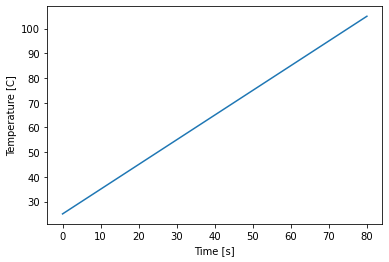

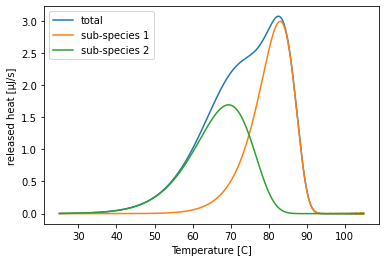

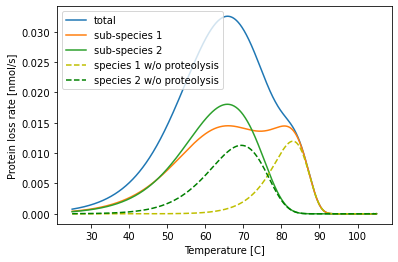

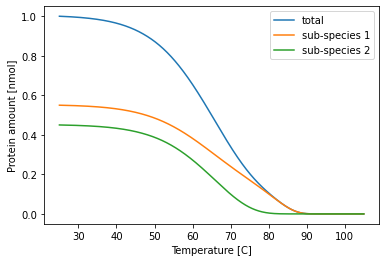

In [53]:
## in this cell: plots

T_C = T(t)-273.15 # temperature in °C
plt.plot(t, T_C)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [C]')
plt.show()

plt.plot(T_C, heat, T_C, heat1, T_C, heat2)
plt.xlabel('Temperature [C]')
plt.ylabel('released heat [µJ/s]')
plt.legend(['total', 'sub-species 1', 'sub-species 2'])
plt.show()

plt.plot(T_C, A_loss, T_C, A1_loss, T_C, A2_loss, T_C, r1*A1, '--y', T_C, r2*A2, '--g')
plt.xlabel('Temperature [C]')
plt.ylabel('Protein loss rate [nmol/s]')
plt.legend(['total', 'sub-species 1', 'sub-species 2', 'species 1 w/o proteolysis', 'species 2 w/o proteolysis'])
plt.show()

plt.plot(T_C, A, T_C, A1, T_C, A2)
plt.xlabel('Temperature [C]')
plt.ylabel('Protein amount [nmol]')
plt.legend(['total', 'sub-species 1', 'sub-species 2'])
plt.show()